Malaria is one of the deadliest diseases. It is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.

However, Malaria diagnosis involves close examination of the blood smear at 100x magnification. This is followed by a manual counting process wherein experts count the number of Red blood cells impacted by parasites. Automatic detection of Malaria from blood smear image is a scalable solution and can save a lot of hours for healthcare industry going a long way in our battle against this deadly disease. In this project, we try to identify from blood smears to predict whether the sample is taken from an infected person.

In [1]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!ls cell_images/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#Storing the base directory
import os

base_dir = os.path.join('./cell_images')

In [5]:
import numpy as np
import pandas as pd

In [6]:
train_df = pd.read_csv('train.csv')
train_df.shape

(19290, 2)

In [7]:
train_df.head()

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria


In [8]:
#understand the distribution of both classes in the training data set
train_df['label'].value_counts()

label
malaria    9645
healthy    9645
Name: count, dtype: int64

From the above cell we can observe that our train set consists of equal samples of both the classes thus we will not face any problem due to class imbalance in the dataset.

<Figure size 1500x1500 with 0 Axes>

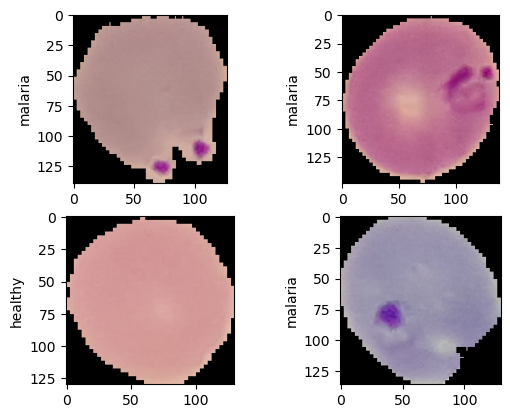

In [9]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

plt.figure(figsize=(15,15))
fig, ax = plt.subplots(nrows=2, ncols=2)

for i in range(2):
    for j in range(2):
        #Reading files after concatenating file name with folder path
        image = imread(os.path.join(base_dir,train_df["filename"][i+2*j]))
        #showing some images of the dataset
        ax[i,j].imshow(image)
        ax[i,j].set_ylabel(train_df["label"][i+2*j])

Data Preparation

since we have textual labels for our images i.e. Parasitized/Uninfected so we will convert them to numerical labels i.e. 0/1

In [12]:
from sklearn import preprocessing

# Create the LabelEncoder object
le = preprocessing.LabelEncoder()

# Fit label Encoder
le.fit(train_df['label'])

# Transform textual labels
labels = le.transform(train_df['label'])

print('0 - ', le.inverse_transform([0])[0])
print('1 - ', le.inverse_transform([1])[0])


0 -  healthy
1 -  malaria


Here we split the dataset into training and validation sets. Training set is the subset of the dataset that is used for training and validation set is used to evaluate the performance of the model after every epoch.

In [13]:
#import required functions
from sklearn.model_selection import train_test_split

#divide the dataset into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'],
                                                                    labels, 
                                                                    test_size=0.2, random_state=42,shuffle=True)
#check the shapes of training and validation sets
print(train_files.shape, val_files.shape)
print(train_labels.shape,val_labels.shape)

(15432,) (3858,)
(15432,) (3858,)


In [14]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [15]:
shapes = []
for i in train_df['filename']:
    image = imread(os.path.join(base_dir,i))
    shapes.append(image.shape)

print('Minimum Dimensions - ',np.min(shapes,axis=0))
print('Maximum Dimensions - ',np.max(shapes,axis=0))
print('Average Dimensions - ',np.mean(shapes,axis=0))

Minimum Dimensions -  [40 49  3]
Maximum Dimensions -  [385 364   3]
Average Dimensions -  [132.9600311  132.58335925   3.        ]


We can see that there are images of different shapes. It is recommended to have images in shape size before going ahead with modeling process and it is also dependent on which feature extractor tool, you are using

Here, we will use pixel value as a feature to classify images in Parasitized/Uninfected images. Although, we have looked at that these images are of different shapes so we will bring all the images in same shape by resizing to 40X40. And, after that convert two dimensional matrix to one dimensional vector. So, for each images, we will have 1600 (40X40) features.

In [17]:
IMG_DIMS=(40,40)
train_features_pixel=[]

for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    train_features_pixel.append(features)

train_features_pixel = np.array(train_features_pixel)

In [19]:
train_features_pixel.shape

(15432, 4800)

In [20]:
IMG_DIMS=(40,40)
val_features_pixel=[]

for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    val_features_pixel.append(features)

val_features_pixel = np.array(val_features_pixel)

In [21]:
val_features_pixel.shape

(3858, 4800)

6. Model1: Model building using Pixel Features

Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_pixel = LogisticRegression()
clf_lr_pixel.fit(train_features_pixel,train_labels)

C:\Anaconda123\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
preditions_train = clf_lr_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  73.03654743390358 %
Validation: Model Accuracy -  68.14411612234318 %


Linear SVM

In [24]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_pixel = LinearSVC(random_state=102)
clf_svc_pixel.fit(train_features_pixel,train_labels)

C:\Anaconda123\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Anaconda123\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=102)

In [25]:
preditions_train = clf_svc_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  77.77993779160187 %
Validation: Model Accuracy -  68.01451529289787 %


Method 2: HOG Features

Image size should be in 64X128(Width X Height) shape to extract HOG features from images. So  changing image shape size to 64X128 first and then extract HOG features.

In [26]:
from skimage.feature import hog

NameError: name 'exposure' is not defined

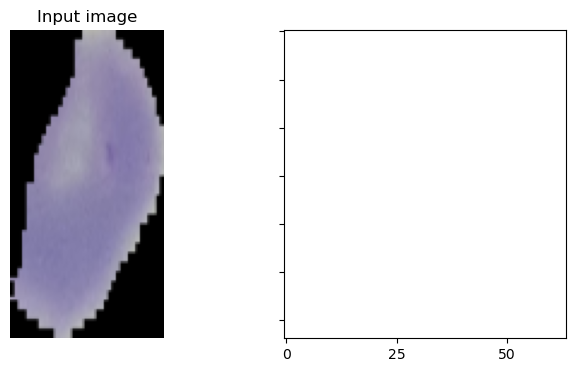

In [31]:
from skimage.color import rgb2gray
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt

# Assuming image is loaded and resized already
image = imread(os.path.join(base_dir, train_files.iloc[index]))
IMG_DIMS = (128, 64)
image_resized = resize(image, IMG_DIMS)

# Convert image to grayscale
image_gray = rgb2gray(image_resized)

# Calculate HOG features
features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)

# Display original and HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_resized, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [28]:
import skimage
print(skimage.__version__)


0.20.0


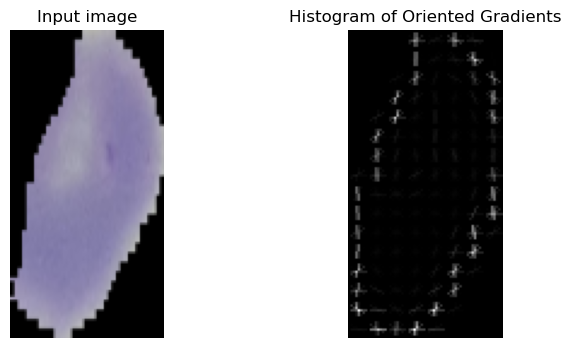

In [32]:
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage import exposure  # Import exposure module for rescale_intensity
import numpy as np
import matplotlib.pyplot as plt

# Assuming image is loaded and resized already
image = imread(os.path.join(base_dir, train_files.iloc[index]))
IMG_DIMS = (128, 64)
image_resized = resize(image, IMG_DIMS)

# Convert image to grayscale
image_gray = rgb2gray(image_resized)

# Calculate HOG features
features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)

# Display original and HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_resized, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [33]:
features.shape

(3780,)

CalculatING HOG features for both training and Validation images

In [35]:
from skimage.color import rgb2gray
from skimage.feature import hog
import numpy as np

# Define the dimensions for resizing
IMG_DIMS = (128, 64)

# Initialize lists to store HOG features
train_features_hog = []
val_features_hog = []

# For Training Images
for i in train_files:
    image = imread(os.path.join(base_dir, i))
    image = resize(image, IMG_DIMS)
    # Convert image to grayscale
    image_gray = rgb2gray(image)
    # Calculate HOG features
    features = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)  # visualize=False for features only
    hog_features = np.reshape(features, (features.shape[0]))
    train_features_hog.append(hog_features)

train_features_hog = np.array(train_features_hog)

# For Validation Images
for i in val_files:
    image = imread(os.path.join(base_dir, i))
    image = resize(image, IMG_DIMS)
    # Convert image to grayscale
    image_gray = rgb2gray(image)
    # Calculate HOG features
    features = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)  # visualize=False for features only
    hog_features = np.reshape(features, (features.shape[0]))
    val_features_hog.append(hog_features)

val_features_hog = np.array(val_features_hog)

# Check the shape of the final lists after processing all the images
train_features_hog.shape, val_features_hog.shape


((15432, 3780), (3858, 3780))

 Model2: Model building using HOG Features

Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_hog = LogisticRegression()
clf_lr_hog.fit(train_features_hog,train_labels)

C:\Anaconda123\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
preditions_train = clf_lr_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  88.67288750648004 %
Validation: Model Accuracy -  81.82996371176775 %


Linear SVM

In [38]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_hog = LinearSVC()
clf_svc_hog.fit(train_features_hog,train_labels)

C:\Anaconda123\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Anaconda123\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [39]:
preditions_train = clf_svc_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  92.29523068947641 %
Validation: Model Accuracy -  79.98963193364438 %


In [40]:
import pickle

In [41]:
with open('logistic_model_hog.pkl', 'wb') as f:
    pickle.dump(clf_lr_hog, f)


In [42]:
with open('svc_model_hog.pkl', 'wb') as f:
    pickle.dump(clf_svc_hog, f)

In [43]:
import streamlit as st
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import pickle

In [44]:
with open('logistic_model_hog.pkl', 'rb') as f:
    clf_lr_hog = pickle.load(f)

In [45]:
with open('svc_model_hog.pkl', 'rb') as f:
    clf_svc_hog = pickle.load(f)

In [50]:
image_resized = resize(image, IMG_DIMS)

    

In [52]:
pip show scikit-image


Name: scikit-imageNote: you may need to restart the kernel to use updated packages.

Version: 0.20.0
Summary: Image processing in Python
Home-page: https://scikit-image.org
Author: 
Author-email: 
License: Files: *
Copyright: 2009-2022 the scikit-image team
License: BSD-3-Clause

Files: doc/source/themes/scikit-image/layout.html
Copyright: 2007-2010 the Sphinx team
License: BSD-3-Clause

Files: skimage/feature/_canny.py
       skimage/filters/edges.py
       skimage/filters/_rank_order.py
       skimage/morphology/_skeletonize.py
       skimage/morphology/tests/test_watershed.py
       skimage/morphology/watershed.py
       skimage/segmentation/heap_general.pxi
       skimage/segmentation/heap_watershed.pxi
       skimage/segmentation/_watershed.py
       skimage/segmentation/_watershed_cy.pyx
Copyright: 2003-2009 Massachusetts Institute of Technology
           2009-2011 Broad Institute
           2003 Lee Kamentsky
           2003-2005 Peter J. Verveer
License: BSD-3-Clause

Files: s

In [53]:
pip install -U scikit-image


  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/50/b2/d5e97115733e2dc657e99868ae0237705b79d0c81f6ced21b8f0799a30d1/scikit_image-0.24.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for imageio>=2.33 from https://files.pythonhosted.org/packages/3d/84/f1647217231f6cc46883e5d26e870cc3e1520d458ecd52d6df750810d53c/imageio-2.34.2-py3-none-any.whl.metadata
  Obtaining dependency information for lazy-loader>=0.4 from https://files.pythonhosted.org/packages/83/60/d497a310bde3f01cb805196ac61b7ad6dc5dcf8dce66634dc34364b20b4f/lazy_loader-0.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
   ---------------------------------------- 0.1/12.8 MB 1.8 MB/s eta 0:00:08
    --------------------------------------- 0.3/12.8 MB 2.5 MB/s eta 0:00:06
   - -------------------------------------- 0.5/12.8 MB 3.0 MB/s

In [62]:
%%writefile app.py

UsageError: %%writefile is a cell magic, but the cell body is empty.


In [69]:
%%writefile app.py
import streamlit as st
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import pickle

# Load the trained models (assuming you saved them as pickle files)
with open('logistic_model_hog.pkl', 'rb') as f:
    clf_lr_hog = pickle.load(f)

with open('svc_model_hog.pkl', 'rb') as f:
    clf_svc_hog = pickle.load(f)

# Define the image dimensions and HOG parameters
IMG_DIMS = (128, 64)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

# Streamlit App
st.title("Malaria Detection from Blood Smear Image")
st.write("Upload an image to predict whether it is parasitized or uninfected.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png"])

if uploaded_file is not None:
    # Read the image
    image = imread(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Convert the image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)
    
    # Resize the image
    image_resized = resize(image, IMG_DIMS)

    # Extract HOG features
    features, hog_image = hog(image_resized, orientations=HOG_ORIENTATIONS, pixels_per_cell=HOG_PIXELS_PER_CELL,
                              cells_per_block=HOG_CELLS_PER_BLOCK, visualize=True)

    # Reshape the features
    features = features.reshape(1, -1)

    # Make predictions using both models
    prediction_lr = clf_lr_hog.predict(features)
    prediction_svc = clf_svc_hog.predict(features)

    # Display the predictions
    st.write(f"Logistic Regression Model Prediction: {'Parasitized' if prediction_lr[0] == 1 else 'Uninfected'}")
    st.write(f"SVM Model Prediction: {'Parasitized' if prediction_svc[0] == 1 else 'Uninfected'}")





Overwriting app.py


In [ ]:
#C100P61ThinF_IMG_20150918_144104_cell_163.png

In [65]:
!pip install -q pyngrok